<div style="text-align: justify;">In this Kaggle notebook, we have employed a variety of advanced machine learning techniques to improve our model's performance. Firstly, we have used <b>Bayesian optimization</b> to tune the hyperparameters of our <b>CatBoost model</b>, which is a powerful gradient boosting algorithm. This approach enables us to automatically search the hyperparameter space, saving us significant amounts of time and manual effort. 
Furthermore, we have utilized <b>Adversarial Validation</b>, a technique that involves training a model to differentiate between training and test data. This approach allows us to identify whether our model is overfitting or underfitting the training data, thus improving its overall robustness.
Additionally, we have implemented <b>Explainable Machine Learning using SHAP</b>, a method that provides insights into how different features affect our model's predictions. This enables us to understand and interpret our model's behavior more effectively, improving our ability to make informed decisions based on its outputs.
We have also employed <b>Pseudo Labeling</b>, a technique that involves using a model's predictions on unlabeled data to generate new labeled data. This approach can significantly increase the amount of training data available to us, improving our model's performance on the test data.
Lastly, we have used <b>Ensemble Learning</b>, which involves combining the outputs of multiple models to create a final prediction. This approach can improve the overall accuracy and robustness of our model, particularly in cases where individual models may struggle to capture the full complexity of the data.</div>

# Import packages and data set

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor

from catboost import CatBoostRegressor
from catboost import Pool, cv, CatBoostRegressor

from bayes_opt import BayesianOptimization
from bayes_opt import BayesianOptimization as BO
import warnings
from sklearn.model_selection import * 
from sklearn.metrics import *
import lightgbm as lgb
import xgboost as xgb

import shap

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [216]:
train_raw = pd.read_csv('dataset/train_data.csv', parse_dates=["startdate"])
test_raw = pd.read_csv('dataset/test_data.csv', parse_dates=["startdate"])
submit = pd.read_csv('dataset/sample_solution.csv')
target = 'contest-tmp2m-14d__tmp2m'

train_raw.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

# Preprocessing Dataset

In [311]:
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

def location_nom(train, test):

    scale = 14

    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)

    all_df = pd.concat([train, test], axis=0)
    all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
    train = all_df.iloc[:len(train)]
    test = all_df.iloc[len(train):].drop(target, axis=1)
    
    return train, test


    
def fill_na(df):
    
    df = df.sort_values(by=['loc_group', 'startdate']).ffill() #try some other filling methods
    
    #columns_with_missing_values = df.columns[df.isnull().any()].tolist()
    #for col in columns_with_missing_values:
    #    df[col].fillna(df[col].mean(), inplace=True)
    """
    col_na = ['nmme0-tmp2m-34w__ccsm30', 'nmme-tmp2m-56w__ccsm3', 'nmme-prate-34w__ccsm3', 'nmme0-prate-56w__ccsm30', 
                'nmme0-prate-34w__ccsm30', 'nmme-prate-56w__ccsm3', 'nmme-tmp2m-34w__ccsm3', 'ccsm30']

    g_means =  ['nmme0-tmp2m-34w__nmme0mean', 'nmme-tmp2m-56w__nmmemean', 'nmme-prate-34w__nmmemean', 'nmme0-prate-56w__nmme0mean', 
                'nmme0-prate-34w__nmme0mean', 'nmme-prate-56w__nmmemean', 'nmme-tmp2m-34w__nmmemean', 'nmme0mean']

    g_1 = ['nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20',
            'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0']

    g_2 = ['nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2',
        'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa']

    g_3 = ['nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 
        'nmme-prate-34w__gfdl', 'nmme-prate-34w__gfdlflora', 'nmme-prate-34w__gfdlflorb', 'nmme-prate-34w__nasa']

    g_4 = [ 'nmme0-prate-56w__cancm30', 'nmme0-prate-56w__cancm40', 'nmme0-prate-56w__ccsm40', 'nmme0-prate-56w__cfsv20',
        'nmme0-prate-56w__gfdlflora0', 'nmme0-prate-56w__gfdlflorb0', 'nmme0-prate-56w__gfdl0', 'nmme0-prate-56w__nasa0']

    g_5 = ['nmme0-prate-34w__cancm30', 'nmme0-prate-34w__cancm40', 'nmme0-prate-34w__ccsm40', 'nmme0-prate-34w__cfsv20',
        'nmme0-prate-34w__gfdlflora0', 'nmme0-prate-34w__gfdlflorb0', 'nmme0-prate-34w__gfdl0', 'nmme0-prate-34w__nasa0']

    g_6 = ['nmme-prate-56w__cancm3', 'nmme-prate-56w__cancm4', 'nmme-prate-56w__ccsm4', 'nmme-prate-56w__cfsv2',
        'nmme-prate-56w__gfdl', 'nmme-prate-56w__gfdlflora', 'nmme-prate-56w__gfdlflorb', 'nmme-prate-56w__nasa']

    g_7 = ['nmme-tmp2m-34w__cancm3', 'nmme-tmp2m-34w__cancm4', 'nmme-tmp2m-34w__ccsm4', 'nmme-tmp2m-34w__cfsv2', 
        'nmme-tmp2m-34w__gfdl','nmme-tmp2m-34w__gfdlflora', 'nmme-tmp2m-34w__gfdlflorb', 'nmme-tmp2m-34w__nasa']

    g_8 = ['cancm30', 'cancm40', 'ccsm40', 'cfsv20', 'gfdlflora0', 'gfdlflorb0', 'gfdl0', 'nasa0']

    gs = [g_1, g_2, g_3, g_4, g_5, g_6, g_7, g_8]
    zip_cols = zip(col_na, gs, g_means)
    
    for c, g, m in tqdm(zip_cols):
        df[c] = (df[m]*9) - df[g].sum(1)
    """ 
        
    return df

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def creat_new_featute(df):
    df['year'] = df['startdate'].dt.year
    df['month'] = df['startdate'].dt.month
    df['day_of_year'] = df['startdate'].dt.dayofyear
    
    df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['day_of_year'])
    df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['day_of_year'])

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])
    
    df.loc[df['month'] >10, 'month_exist_in_test'] = 1
    df.loc[df['month'] <11, 'month_exist_in_test'] = 0

    return df

def target_min_max(train, test):
    # Concatenate train and test data
    all_df = pd.concat([train, test], axis=0)

    # Create new feature
    #all_df['target_loc_group_max'] = all_df.groupby(['loc_group'])[target].transform('max')
    #all_df['target_loc_group_min'] = all_df.groupby(['loc_group'])[target].transform('min')
    #all_df['target_loc_group_std'] = all_df.groupby(['loc_group'])[target].transform('std')
    #all_df['target_loc_group_mean'] = all_df.groupby(['loc_group'])[target].transform('mean')

    #all_df['target_cr_max'] = all_df.groupby(['climateregions__climateregion'])[target].transform('max')
    #all_df['target_cr_min'] = all_df.groupby(['climateregions__climateregion'])[target].transform('min')
    #all_df['target_cr_std'] = all_df.groupby(['climateregions__climateregion'])[target].transform('std')
    #all_df['target_cr_mean'] = all_df.groupby(['climateregions__climateregion'])[target].transform('mean')

    all_df['target_loc_group_month_max'] = all_df.groupby(['loc_group','month'])[target].transform('max')
    all_df['target_loc_group_month_min'] = all_df.groupby(['loc_group','month'])[target].transform('min')
    all_df['target_loc_group_month_std'] = all_df.groupby(['loc_group','month'])[target].transform('std')
    all_df['target_loc_group_month_mean'] = all_df.groupby(['loc_group','month'])[target].transform('mean')
    
    all_df['target_cr_month_max'] = all_df.groupby(['climateregions__climateregion','month'])[target].transform('max')
    all_df['target_cr_month_min'] = all_df.groupby(['climateregions__climateregion','month'])[target].transform('min')
    all_df['target_cr_month_std'] = all_df.groupby(['climateregions__climateregion','month'])[target].transform('std')
    all_df['target_cr_month_mean'] = all_df.groupby(['climateregions__climateregion','month'])[target].transform('mean')

    
    # Split back up
    train = all_df.iloc[:len(train)]
    test = all_df.iloc[len(train):]
    
    return train, test

def categorical_encode(train, test):
    """
    le = LabelEncoder()
    train['climateregions__climateregion'] = le.fit_transform(train['climateregions__climateregion'])
    test['climateregions__climateregion'] = le.transform(test['climateregions__climateregion'])
    """
    
    ohe = OneHotEncoder()
    
    train_encoded = ohe.fit_transform(train[['climateregions__climateregion']])
    test_encoded = ohe.transform(test[['climateregions__climateregion']])
    
    train = train.drop(['climateregions__climateregion'], axis=1)
    test = test.drop(['climateregions__climateregion'], axis=1)
    
    train_encoded = pd.DataFrame(train_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    test_encoded = pd.DataFrame(test_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    
    train = pd.concat([train, train_encoded], axis=1)
    test = pd.concat([test, test_encoded], axis=1)
    
    
    return train, test

## Checking correlation

In [236]:
## Identify correlated features to drop that fall above a correlation threshold 
## https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/08/02-Feature-selection-I-selecting-for-feature-information.html 

def identify_correlated(df, threshold):
    
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    
    return features_to_drop

In [237]:
# afterwards i should print out the columns that are of high importance from the models
# perform PCA and see if it determines the same features as the corr_matrix
# at.96 the score is ~1.24 (~51 columns dropped)
# at .70 the score is ~1.4 (~100+ columns dropped)
# at .80 the score is ~0.968 (100 columns dropped) - but why were these columns so unimportant that dropping it had a better outcome as compared to the other trials with .95 and .70 ?
# **Besides the fact that they were highly correlated - at .70 had more columns but dropping the columns identifed at .70 had a worse score than .80
features_to_drop = identify_correlated(train_raw, .8)

In [238]:
print(len(features_to_drop))
print(features_to_drop)

100
['index', 'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-prate-34w__gfdlflora', 'nmme-prate-34w__gfdlflorb', 'nmme-prate-34w__nasa', 'nmme-prate-34w__nmmemean', 'contest-wind-h100-14d__wind-hgt-100', 'nmme0-prate-56w__cancm30', 'nmme0-prate-56w__cancm40', 'nmme0-prate-

## Engineering

In [312]:
def feature_engineering(train_raw, test_raw):
    
    train, test = location_nom(train_raw, test_raw)
    train = fill_na(train)
    #train = add_season(train)
    #test = add_season(test)
    train = creat_new_featute(train)
    test = creat_new_featute(test)
    
    train, test = target_min_max(train, test)
    train, test = categorical_encode(train, test)

    drop_cols = ['index', 'startdate', 'lat', 'lon','month','year','loc_group','day-of-year', target]
    
    #drop_cols = ['index', 'lat', 'lon',\
    #             'day-of-year']
    
    features = [col for col in train.columns if ((col not in features_to_drop) and (col not in drop_cols))]
    #features = [col for col in train.columns if col not in drop_cols]
    
    X = train[features]
    X_test = test[features]
    
    y = train[target]

    return X, y, X_test

In [313]:
X, y, X_test = feature_engineering(train_raw.copy(), test_raw.copy())

In [55]:
temp_agg

,year,month,contest-tmp2m-14d__tmp2m
0,2014,9,17.370369
1,2014,10,12.073068
2,2014,11,2.345845
3,2014,12,0.182899
4,2015,1,2.231912
5,2015,2,2.271760
6,2015,3,9.467537
7,2015,4,11.726717
8,2015,5,15.484178
9,2015,6,22.268714


# Train and validation set split

In [314]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=48)
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_val.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (300587, 171)    |   Val_shape: (75147, 171)    |   Test_shape: (31354, 171)


# Adversarial Validation

Adversarial Validation is a technique used to ensure that the distribution of data in the training set is similar to that of the test set. This is important because if the data in the training set is not representative of the test set, the model's predictions may not be accurate.

To perform Adversarial Validation, the following steps are taken:

1. Combine the train and test features into a single set
1. Create a target label to indicate whether a sample is from the train or test set
1. Build a model to classify samples as belonging to the train or test set

If the model is able to accurately distinguish between train and test samples, this indicates that there are features in the data that are different between the two sets. Adversarial Validation can be used to identify these features by using the feature importance generated by the model and evaluating the separation between the train and test datasets using the AUC metric.

Reference: Pan, J., Pham, V., Dorairaj, M., Chen, H., & Lee, J. Y. (2020). Adversarial validation approach to concept drift problem in user targeting automation systems at uber. [arXiv preprint arXiv:2004.03045](https://arxiv.org/abs/2004.03045).

In [ ]:
import lightgbm as lgb

def run_adversial_validation(train_X_ml, test_X_ml):
    
    lgb_params = {'n_estimators':100,
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'verbose': 0
                    }
    # combine train & test features, create label to identify test vs train
    ad_y = np.array([1]*train_X_ml.shape[0] + [0]*test_X_ml.shape[0])
    ad_X = pd.concat([train_X_ml, test_X_ml])

    # evaluate model performance using cross-validation
    lgb_data = lgb.Dataset(ad_X, ad_y)
    cv_lgb = lgb.cv(lgb_params, lgb_data)

    print("Adversarial Validation AUC Score: {}".format(cv_lgb['auc-mean'][-1]))
    
    # train model & get feature importance
    ad_val_mod = lgb.train(lgb_params, lgb_data)
    
    print(pd.DataFrame(
        {'feat':ad_X.columns, 
         'imp':ad_val_mod.feature_importance()}).sort_values('imp', ascending = False))
    
    return ad_val_mod

In [ ]:
ad_val_mod = run_adversial_validation(X_train, X_test)

It seems that there is a concept drift between train and test dataset and removing features like "contest-pevpr-sfc-gauss-14d__pevpr" and "nmme0-tmp2m-34w__cancm30" might help to increase the performance. 

In [ ]:
# X.drop(['contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30'], inplace = True)
# X_test.drop(['contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30'], inplace = True)

# Bayesian Optimization for CatBoost

[Here's](https://en.wikipedia.org/wiki/Bayesian_optimization) a wikipedia article about Bayesian Optimization, it's essentially a way to find good parameters by searching for these parameters sequentially. So the next parameter search values depend on the performance of the previous parameter values. This is a popular technique for finding optimal parameters. This may take some time to run. Also, you can tune many parameters, below are just some of the parameters that I choose to tune. For this notebook, I'm going to fix the number of estimators to be 100 to save time when running this notebook, but you can increase it to your liking or tune that parameter too if you'd like. You can change the number of iterations and initial points.

In [315]:
# source: https://medium.com/ai-in-plain-english/catboost-cross-validated-bayesian-hyperparameter-tuning-91f1804b71dd

X1, Y1 = X.copy(), y.copy()

In [316]:
Use_BO = False

if Use_BO:
    #n_estimators,
    # num_leaves
    def CB_opt(depth, learning_rate, subsample, l2_leaf_reg, model_size_reg): 

        scores = []
    #     skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1944)
        trainx, valx, trainy, valy = train_test_split(X1, Y1, test_size=0.33, random_state=42)

        reg = CatBoostRegressor(   
                                        verbose = 0,
                                        #iterations=10,
                                        n_estimators = 20,
                                        learning_rate = learning_rate,
                                        subsample = subsample, 
                                        l2_leaf_reg = l2_leaf_reg,
                                        max_depth = int(depth),
                                        #num_leaves = int(num_leaves),
                                        random_state = 1314,
                                        #grow_policy = "Lossguide",
    #                                     max_bin = int(max_bin),  
                                        use_best_model = True, 
                                        # bootstrap_type='Bayesian',
                                        loss_function='RMSE',
                                        model_size_reg = model_size_reg
                                    )

        reg.fit(trainx, trainy, eval_set = (valx, valy))
        y_pred = reg.predict(valx)
        scores.append(rmse(valy, y_pred))

        return 1/np.mean(scores)

    #"n_estimators": (150,1200),
    # "num_leaves": (100,150),
    # "max_bin":(150,300),
    pbounds = {
               "depth": (6, 7),
               "learning_rate": (0.09, 0.0980689972639084),
               "subsample":(0.7, 0.800000011920929),
               "l2_leaf_reg":(2,4),
               "model_size_reg": (0.48, 0.5)
    }

    optimizer = BayesianOptimization(f = CB_opt, pbounds = pbounds,  verbose = 2, random_state = 1212)

    optimizer.maximize(init_points = 7, n_iter = 30, acq = 'ucb', alpha = 1e-6)

    print(optimizer.max)

    max_bo_params = optimizer.max['params']

    max_bo_params

In [317]:
Use_BO_result = False

if Use_BO_result:
    opt_params = {
              'iterations':30000,
              'verbose':0,
              'learning_rate' : max_bo_params['learning_rate'],
              'subsample' : max_bo_params['subsample'], 
              'l2_leaf_reg' : max_bo_params['l2_leaf_reg'],
              'max_depth' : int(max_bo_params['depth']), 
              'use_best_model' : True, 
              'loss_function' : 'RMSE',
              'model_size_reg' : max_bo_params['model_size_reg'],
              'task_type':'GPU'
             }
else:
    opt_params = {
          'iterations':30000,
          'verbose':0,
          'learning_rate' : 0.0980689972639084,
          'subsample' : 0.7443133148363695, 
          'l2_leaf_reg' : 2.3722386345448316,
          'max_depth' : int(6.599144674342465),
          'use_best_model' : True, 
          'loss_function' : 'RMSE',
          'model_size_reg' : 0.4833187897595954,
          #'task_type':'GPU'
         }

In [318]:
## catBoost Pool object
train_pool = Pool(data=X1,label = Y1)

X_train, X_test2, y_train, y_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

In [319]:
bst = CatBoostRegressor(**opt_params)

bst.fit(train_pool, eval_set=(X_test2, y_test), plot=True,silent=True)

print(bst.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 0.09501309953338591}, 'validation': {'RMSE': 0.09500347468868083}}


# Feature Importance

Text(0.5, 1.0, 'Feature Importance')

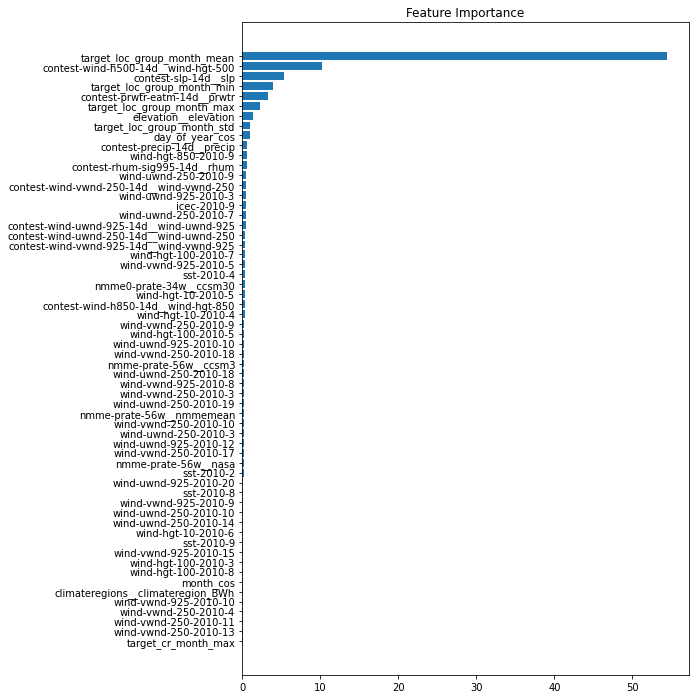

In [320]:
feature_importance = bst.feature_importances_
max_features = 60
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

# Machine Learning Explainability

<div style="text-align: justify;">In this section, we showcase a sample of SHAP explainability evaluation for our model. SHAP (SHapley Additive exPlanations) is a popular approach for providing model interpretability by measuring the contribution of each feature to a prediction. This enables us to identify which features have the greatest impact on our model's outputs, and how they are related to the predicted values. 
To perform the SHAP evaluation, we first generate a set of test data and extract the features we want to evaluate. We then use the SHAP library to compute the SHAP values for each feature, which represent the change in the predicted value as a result of changing the feature value while holding all other features constant. These values are visualized using a SHAP summary plot, which shows the features ranked by their importance and the direction of their impact on the predicted value. Through the SHAP summary plot, we can observe the top contributing features to our model's predictions, and how they are positively or negatively correlated with the output. This enables us to gain insights into the underlying relationships between the features and the target variable, improving our understanding of how our model makes its predictions. Overall, the SHAP explainability evaluation provides a valuable tool for gaining insights into the inner workings of our model and making informed decisions based on its outputs.</div>

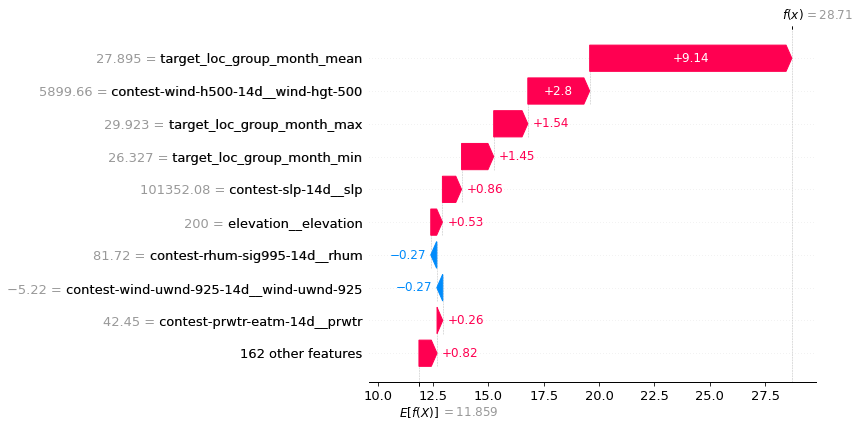

In [321]:
explainer = shap.Explainer(bst)
shap_values = explainer(X1)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# Pseudo Labeling and Postprocessing

In [322]:
# Pseudo Labelling
train_pseudo = X_test.copy()
ddf = pd.read_csv('y_pred_cat14.csv')
y_test_pred  = ddf[target].values.flatten() #bst.predict(X_test)
train_pseudo[target] = y_test_pred

X_train_pseudo = X_train.copy() 
X_train_pseudo[target] = y_train

train_mod = pd.concat([X_train.copy(), train_pseudo], axis=0).reset_index(drop=True)
features = [c for c in X_test.columns if (c != 'id')]
display(train_mod)

XX = train_mod[features]
yy = train_mod[target]
y_oof_pred = np.zeros(len(yy))

X_testt = X_test[features].values
y_test_pred2 = np.zeros(len(X_testt))

,contest-rhum-sig995-14d__rhum,nmme0-prate-34w__ccsm30,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__ccsm3,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-wind-uwnd-250-14d__wind-uwnd-250,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,elevation__elevation,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__nip,wind-hgt-850-2010-2,wind-hgt-850-2010-4,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-2,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,wind-uwnd-925-2010-7,wind-uwnd-925-2010-8,wind-uwnd-925-2010-9,wind-uwnd-925-2010-10,wind-uwnd-925-2010-11,wind-uwnd-925-2010-12,wind-uwnd-925-2010-13,wind-uwnd-925-2010-14,wind-uwnd-925-2010-15,wind-uwnd-925-2010-16,wind-uwnd-925-2010-17,wind-uwnd-925-2010-18,wind-uwnd-925-2010-19,wind-uwnd-925-2010-20,wind-hgt-10-2010-3,wind-hgt-10-2010-4,wind-hgt-10-2010-5,wind-hgt-10-2010-6,wind-hgt-10-2010-7,wind-hgt-10-2010-8,wind-hgt-10-2010-9,wind-hgt-10-2010-10,wind-hgt-100-2010-2,wind-hgt-100-2010-3,wind-hgt-100-2010-4,wind-hgt-100-2010-5,wind-hgt-100-2010-6,wind-hgt-100-2010-7,wind-hgt-100-2010-8,wind-hgt-100-2010-9,wind-hgt-100-2010-10,wind-vwnd-925-2010-1,wind-vwnd-925-2010-2,wind-vwnd-925-2010-3,wind-vwnd-925-2010-4,wind-vwnd-925-2010-5,wind-vwnd-925-2010-6,wind-vwnd-925-2010-7,wind-vwnd-925-2010-8,wind-vwnd-925-2010-9,wind-vwnd-925-2010-10,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,day_of_year,day_of_year_sin,day_of_year_cos,month_sin,month_cos,month_exist_in_test,target_loc_group_month_max,target_loc_group_month_min,target_loc_group_month_std,target_loc_group_month_mean,target_cr_month_max,target_cr_month_min,target_cr_month_std,target_cr_month_mean,climateregions__climateregion_BSh,climateregions__climateregion_BSk,climateregions__climateregion_BWh,climateregions__climateregion_BWk,climateregions__climateregion_Cfa,climateregions__climateregion_Cfb,climateregions__climateregion_Csa,climateregions__climateregion_Csb,climateregions__climateregion_Dfa,climateregions__climateregion_Dfb,climateregions__climateregion_Dfc,climateregions__climateregion_Dsb,climateregions__climateregion_Dsc,climateregions__climateregion_Dwa,climateregions__climateregion_Dwb,contest-tmp2m-14d__tmp2m
0,54.53,38.16,100904.79,0.18,39.36,9.14,30.56,7.59,10.24,11.71,11.12,1453.56,-0.83,5654.70,1700.0,-61.93,-100.57,-215.99,-44.71,-64.49,-59.10,-1.88,36.90,-186.24,24.66,45.51,82.12,-111.96,71.84,65.99,95.19,-46.38,96.36,67.84,-58.37,64.37,-31

In [323]:
yy[np.isnan(yy)] = 0
train_pool = Pool(data=XX,label = yy)

X_train3, X_test3, y_trai3, y_test3 = train_test_split(XX, yy, test_size=0.2, random_state=48)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [324]:
bst2 = CatBoostRegressor(**opt_params)
bst2.fit(train_pool, eval_set=(X_test3, y_test3), plot=True,silent=True)
print(bst2.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 0.006307793567521003}, 'validation': {'RMSE': 0.00628672703218862}}


In [325]:
y_pred_cat = bst2.predict(X_test)

# Ensemble Learning

## lightgbm

In [328]:
# set up parameters for LightGBM
params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth': 8,
          'num_leaves': 31,
          'learning_rate': 0.03,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'early_stopping_round': 50,
          'min_data_in_leaf': 100,
          'subsample_for_bin': 20000,
          'n_estimators': 15000,
          'early_stopping_rounds': 50
          #'device_type': 'gpu'
         }

reg_lgb = lgb.LGBMRegressor(**params)

reg_lgb.fit(X_train3, y_trai3, eval_set=[(X_train3, y_trai3), (X_test3, y_test3)])

y_pred_lgb = reg_lgb.predict(X_test)

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## xgboost

In [329]:
#### set up parameters for XGBoost
# list of learning_rates to test [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
print("Training and predicting using xgboost")

# Define the search space for the hyperparameters
params = {'base_score': 0.5, 
          'booster': 'gbtree',
          #'tree_method': 'gpu_hist',
          'n_estimators': 15000,
          'objective': 'reg:squarederror',
          'max_depth': 6,
          'subsample': 0.5,
          'colsample_bytree': 0.5,
          'gamma': 1.4,
          'min_child_weight': 7,
          'learning_rate': 0.01}

reg_xgb = xgb.XGBRegressor(**params)

reg_xgb.fit(X_train3, y_trai3, eval_set=[(X_train3, y_trai3), (X_test3, y_test3)], verbose=1000)


# make predictions on the test data
y_pred_xgb = reg_xgb.predict(X_test)

Training and predicting using xgboost
[0]	validation_0-rmse:4.67820	validation_1-rmse:4.70550
[1000]	validation_0-rmse:0.11303	validation_1-rmse:0.12729
[2000]	validation_0-rmse:0.08721	validation_1-rmse:0.10275
[3000]	validation_0-rmse:0.07762	validation_1-rmse:0.09351
[4000]	validation_0-rmse:0.07321	validation_1-rmse:0.08920
[5000]	validation_0-rmse:0.07071	validation_1-rmse:0.08671
[6000]	validation_0-rmse:0.06881	validation_1-rmse:0.08487
[7000]	validation_0-rmse:0.06737	validation_1-rmse:0.08344
[8000]	validation_0-rmse:0.06645	validation_1-rmse:0.08255
[9000]	validation_0-rmse:0.06555	validation_1-rmse:0.08164
[10000]	validation_0-rmse:0.06486	validation_1-rmse:0.08095
[11000]	validation_0-rmse:0.06434	validation_1-rmse:0.08045
[12000]	validation_0-rmse:0.06383	validation_1-rmse:0.07996
[13000]	validation_0-rmse:0.06343	validation_1-rmse:0.07958
[14000]	validation_0-rmse:0.06300	validation_1-rmse:0.07914
[14999]	validation_0-rmse:0.06268	validation_1-rmse:0.07883


## ensemble

In [330]:
submit_cat = submit.copy()
submit_cat[target] = y_pred_cat
submit_cat.to_csv('y_pred_cat15.csv', index = False)

submit_lgb = submit.copy()
submit_lgb[target] = y_pred_lgb
submit_lgb.to_csv('y_pred_lgb15.csv', index = False)

submit_xgb = submit.copy()
submit_xgb[target] = y_pred_xgb
submit_xgb.to_csv('y_pred_xgb15.csv', index = False)

# Submission

In [332]:
ensemble_preds = y_pred_cat*0.6+y_pred_lgb*0.4#+y_pred_xgb*0.1 #+0.1*y_pred_mlp
submit[target] = ensemble_preds
submit.to_csv('submission69.csv', index = False)

In [364]:
import random

In [366]:
submit67[target] = submit67[target].apply(lambda x: x + random.uniform(-0.7, 0.7))

In [367]:
submit67[target].mean()

14.729687239250232

In [368]:
submit67[target].std()

5.663749442825299

In [369]:
submit67.to_csv('submission70.csv', index = False)

In [371]:
submit[target] = y_pred_cat15[target]*0.5 + submit51[target]*0.5
submit.to_csv('submission72.csv', index = False)

In [353]:
submit67 = pd.read_csv("submission67.csv")
submit64 = pd.read_csv("submission64.csv")
submit63 = pd.read_csv("submission63.csv")
submit62 = pd.read_csv("submission62.csv")
submit52 = pd.read_csv("submission52.csv")
submit51 = pd.read_csv("submission51.csv")
y_pred_cat15 = pd.read_csv("y_pred_cat15.csv")
y_pred_cat14 = pd.read_csv("y_pred_cat14.csv")

In [365]:
submit67[target].mean()

14.729951821365804

In [358]:
submit67[target].std()

5.652074503900643

In [355]:
submit64[target].std()

5.6518162195912645

In [357]:
submit63[target].std()

5.6519711359598785

In [359]:
submit62[target].std()

5.652057208737977

In [360]:
submit52[target].std()

5.65269222287654

In [361]:
submit51[target].std()

5.6522631534673256

In [362]:
y_pred_cat15[target].std()

5.6523554045087065

In [363]:
y_pred_cat14[target].std()

5.652458924149897

In [344]:
submit61 = pd.read_csv("submission61.csv")
submit61[target].mean()

14.809930427364442

In [351]:
y_pred_lgb14 = pd.read_csv("y_pred_lgb14.csv")

In [352]:
y_pred_lgb14[target].mean()

14.73000741082922

List of Kaggle Notebooks Used as a Reference

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">

* [[WiDS 2023] Simple basline - RMSE 1.14](https://www.kaggle.com/code/ducanger/wids-2023-simple-basline-rmse-1-14) by [DAT DO](https://www.kaggle.com/ducanger) used as base especially for preprocessing.
* [🔥 EDA & ML on Game Play 🎮 (ongoing)](https://www.kaggle.com/code/nguyenthicamlai/eda-ml-on-game-play-ongoing) by [Nguyen Thi Cam Lai](https://www.kaggle.com/nguyenthicamlai) used for HTML-based headers
* [[WiDS 2021] Tips & Tricks (CatBoost Version)](https://www.kaggle.com/code/kooaslansefat/tips-tricks-catboost-version) used for hyperparameter tunning for CatBoost and adversarial validation
* [WiDS2023_Data_Buddies](https://www.kaggle.com/code/nicholasdominic/wids2023-data-buddies) by [Nicholas Dominic](https://www.kaggle.com/nicholasdominic) for Ensemble Learning